# Test fitting and sampling a GP after refactoring to produce the `SkillsGPMAP` and `SkillsGPMCMC` classes.

## Setup

In [1]:
import os
import sys

os.chdir("..")

In [258]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist

In [270]:
from src import load, munge
import src.models.gp
import src.stats

In [271]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)
importlib.reload(src.stats)

<module 'src.stats' from '/Users/yl3/github/dota2/src/stats.py'>

## Load data.

### Load matches.

In [5]:
matches = load.all_matches_df()

In [6]:
matches_ti9 = matches.loc[matches.league_name == "The International 2019"]
matches_ti9.shape

(268, 15)

In [7]:
players_mat_ti9 = munge.make_match_players_matrix(
    matches_ti9.radiant_players, matches_ti9.dire_players)
players_mat_ti9.shape

(268, 240)

### Load players.

In [8]:
players = src.munge.match_df_to_player_df(matches_ti9)

In [9]:
players.loc[players_mat_ti9.columns[:5]]

,name,team,team_id
3916428,EGM,Bald,7237270
3940262,March,Team Jinesbrus,7225724
4281729,syndereN,Anti-MagE-,7247587
6922000,pieliedie,Forward Gaming,6214538
10366616,Sneyking,Forward Gaming,6214538


## Test `SkillsGPMAP`

In [116]:
two_years_in_ms = 2 * 365 * 24 * 60 * 60 * 1000

In [329]:
importlib.reload(src.models.gp)
gp_map = src.models.gp.SkillsGPMAP(
    players_mat_ti9,
    matches_ti9.startTimestamp.values,
    matches_ti9.radiantVictory,
    players.loc[players_mat_ti9.columns].name,
    "exponential",
    {"scale": two_years_in_ms},
    radi_prior_sd=100,  # Non-informative prior
    logistic_scale=1
)

In [330]:
gp_map.fit()

     fun: -7251.013162611372
     jac: array([-5.23160468e-06, -5.52552992e-07,  3.76533669e-06, ...,
        4.06530148e-06,  1.18461602e-05, -6.10667587e-06])
 message: 'Optimization terminated successfully.'
    nfev: 18
    nhev: 2144
     nit: 16
    njev: 33
  status: 0
 success: True
       x: array([-0.28622809, -0.28618617, -0.28613725, ..., -0.16674693,
       -0.16678353, -0.08426558])


In [337]:
matches_ti9.assign(
        win_prob=gp_map.radi_win_probs(gp_map.fitted.x[:-1], 
                                       gp_map.fitted.x[-1])).loc[
    :, ["radiant_name", "dire_name", "win_prob", "radiantVictory"]]

,radiant_name,dire_name,win_prob,radiantVictory
matchId,,,,
4904311356,J.Storm,Forward Gaming,0.177270,False
4904261164,Forward Gaming,J.Storm,0.796778,True
4904218149,J.Storm,Forward Gaming,0.177346,False
4904171017,Forward Gaming,J.Storm,0.796620,False
4904062522,beastcoast,J.Storm,0.395269,False
4903974414,beastcoast,J.Storm,0.395441,False
4903679968,Chaos Esports Club,The Final Tribe,0.612977,True
4903566049,The Final Tribe,Chaos Esports Club,0.347967,False
4903441151,Chaos Esports Club,The Final Tribe,0.612724,True


### Radiant advantage.

In [328]:
gp_map.win_prob(gp_map.fitted.x[-1])

0.4789460616716572

## Test `SkillsGPMCMC`.

In [298]:
importlib.reload(src.models.gp)
gp_mcmc = src.models.gp.SkillsGPMCMC(
    players_mat=players_mat_ti9,
    start_times=matches_ti9.startTimestamp.values,
    radiant_win=matches_ti9.radiantVictory,
    player_ids=players.loc[players_mat_ti9.columns].name,
    cov_func_name="exponential",
    cov_func_kwargs={"scale": two_years_in_ms},
    radi_prior_sd=100,  # Non-informative prior
    logistic_scale=1,
    propose_sd=0.1,
    save_every_n_iter=10
)

In [299]:
print(gp_mcmc.samples[0])

[0] log_posterior: 7206.0243463345805, radi_adv: 0.0, skills: [0. 0. 0. ... 0. 0. 0.]


### Run 1,000 iterations.

In [300]:
gp_mcmc.iterate(1000)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35


In [301]:
for s in gp_mcmc.samples[-3:]:
    print(s)

[980] log_posterior: 5904.581454431751, radi_adv: 0.019196540674366228, skills: [ 0.1148515   0.10258393  0.09480939 ... -0.98546504 -0.97584561
 -0.97221445]
[990] log_posterior: 5880.793151518916, radi_adv: -0.3055250417731944, skills: [ 0.44522972  0.43326409  0.42512612 ... -1.31469865 -1.30926362
 -1.30001897]
[1000] log_posterior: 5898.027377167178, radi_adv: -0.33768903995539207, skills: [ 0.63353812  0.62371447  0.6115938  ... -1.58637214 -1.5765002
 -1.57014383]


Text(0.5, 1.0, 'log-posterior')

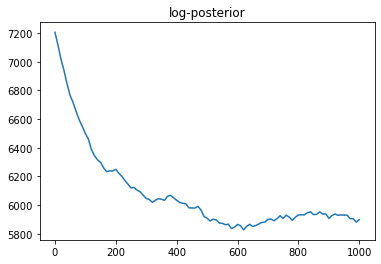

In [302]:
plt.plot([x.iter for x in gp_mcmc.samples],
         [x.log_posterior for x in gp_mcmc.samples])
plt.title("log-posterior")

Text(0.5, 1.0, 'Radiant advantage')

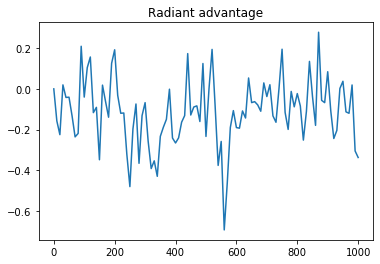

In [303]:
plt.plot([x.iter for x in gp_mcmc.samples],
         [x.radi_adv for x in gp_mcmc.samples])
plt.title("Radiant advantage")

### Test `GPSampleSet.player_skill_by_sample()`

In [307]:
player_skill_by_sample = gp_mcmc.player_skill_by_sample("pieliedie")

In [308]:
player_skill_by_sample.head()

matchId,4904311356,4904261164,4904218149,4904171017,4901998619,4901925673,4901799568,4901733286,4899990684,4899794936,4898286553,4898190830,4898118360,4898062038,4897799006
iter,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.513812,0.515350,0.511435,0.520209,0.533079,0.531164,0.530892,0.532154,0.534532,0.540405,0.538630,0.537202,0.534018,0.528461,0.534129
20,0.557054,0.557127,0.555156,0.559636,0.569534,0.570897,0.567272,0.569417,0.575780,0.579739,0.577970,0.570036,0.567888,0.567461,0.571478
30,1.156824,1.157129,1.159807,1.164496,1.156317,1.156616,1.148456,1.147659,1.149578,1.154969,1.159697,1.147762,1.147594,1.152199,1.156420
40,1.408962,1.408401,1.415996,1.421146,1.423698,1.419587,1.408284,1.405364,1.397874,1.403994,1.391160,1.372399,1.367447,1.370318,1.373737


In [309]:
player_skill_by_sample.shape

(101, 15)

### Average skill of player across matches and samples.

In [310]:
player = 3916428

In [311]:
skills_by_player = pd.Series(
    [np.mean(gp_mcmc.player_skill_by_sample(player).values)
     for player in gp_mcmc.player_ids.index],
    index=gp_mcmc.player_ids.index,
    name="skill")
skills_by_player.sort_values(ascending=False).head()

164685175    1.564491
194521913    1.359586
105045291    1.288276
10366616     1.229027
113874152    1.192072
Name: skill, dtype: float64

In [312]:
team_skills = (players.assign(skill=skills_by_player)
               .sort_values("skill")
               .groupby("team").agg({"skill": "sum"})
               .sort_values("skill", ascending=False))
team_skills

,skill
team,
Forward Gaming,3.336828
Infamous Gaming,2.478382
paiN Gaming,1.679833
J.Storm,1.656416
Vega Squadron,1.524301
Mineski,1.341294
Natus Vincere,1.274151
beastcoast,1.256117
Chaos Esports Club,1.225362


In [313]:
src.stats.win_prob_mat(team_skills, 1).iloc[:15, :15]

team,Forward Gaming,Infamous Gaming,paiN Gaming,J.Storm,Vega Squadron,Mineski,Natus Vincere,beastcoast,Chaos Esports Club,Team Jinesbrus,CDEC,Winstrike Team,Royal Never Give Up,The Final Tribe,EGOBOYS
team,,,,,,,,,,,,,,,
Forward Gaming,0.000000,0.702336,0.839834,0.842959,0.859667,0.880327,0.887222,0.889014,0.892013,0.897567,0.913084,0.927560,0.928691,0.933590,0.937195
Infamous Gaming,0.297664,0.000000,0.689664,0.694653,0.721935,0.757145,0.769277,0.772462,0.777822,0.787853,0.816593,0.844401,0.846617,0.856282,0.863470
paiN Gaming,0.160166,0.310336,0.000000,0.505854,0.538805,0.583836,0.600052,0.604372,0.611702,0.625622,0.667053,0.709467,0.712951,0.728335,0.739981
J.Storm,0.157041,0.305347,0.494146,0.000000,0.532981,0.578135,0.594419,0.598760,0.606125,0.620122,0.661832,0.704617,0.708135,0.723678,0.735450
Vega Squadron,0.140333,0.278065,0.461195,0.467019,0.000000,0.545625,0.562213,0.566647,0.574183,0.588544,0.631662,0.676398,0.680099,0.696495,0.708960
Mineski,0.119673,0.242855,0.416164,0.421865,0.454375,0.000000,0.516779,0.521281,0.528951,0.543624,0.588156,0.635123,0.639044,0.656482,0.669811
Natus Vincere,0.112778,0.230723,0.399948,0.405581,0.437787,0.483221,0.000000,0.504508,0.512195,0.526924,0.571801,0.619427,0.623417,0.641185,0.654796
beastcoast,0.110986,0.227538,0.395628,0.401240,0.433353,0.478719,0.495492,0.000000,0.507688,0.522426,0.567380,0.615166,0.619174,0.637026,0.650708
Chaos Esports Club,0.107987,0.222178,0.388298,0.393875,0.425817,0.471049,0.487805,0.492312,0.000000,0.514748,0.559816,0.607860,0.611896,0.629885,0.643686


### Test `GPSampleSet.team_skill_by_sample()`

In [316]:
radi_skill = gp_mcmc.team_skill_by_sample(sample_slice=slice(-10, None))
radi_skill

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
910,1.817200,3.593600,1.799524,3.539831,0.137083,0.168323,0.387981,0.164296,0.365433,0.355108,...,0.175029,0.203434,1.507364,0.206498,0.196781,-1.985912,-3.239662,-2.029870,-0.376802,0.277373
920,1.287221,3.068702,1.266770,3.026481,0.043534,0.080782,0.833831,0.068378,0.819308,0.827856,...,0.048132,-0.804694,1.143729,-0.814507,0.071647,-2.344165,-3.663635,-2.388418,0.053091,-0.767203
930,0.322913,2.351241,0.294735,2.310651,-0.624578,-0.597842,0.765674,0.405420,0.750542,0.767853,...,0.531617,-0.937596,0.808544,-0.941405,0.547774,-1.541605,-3.692581,-1.578489,-0.011554,-0.891515
940,1.319869,2.898964,1.289419,2.847026,-0.402202,-0.388246,0.551095,0.215200,0.519369,0.531195,...,0.666399,-0.339679,-0.068445,-0.353030,0.683421,-2.141963,-2.891223,-2.176065,0.166585,-0.287178
950,0.777257,2.975270,0.734237,2.922691,0.659706,0.666248,1.328930,-0.129033,1.297307,1.293141,...,0.529998,-0.889207,0.073048,-0.893594,0.541280,-2.456849,-3.669217,-2.489919,-0.155204,-0.830437
960,1.092764,3.213586,1.055410,3.165079,0.941528,0.944587,0.056286,-0.670833,0.041326,0.025013,...,-0.202644,-0.540797,0.605763,-0.542510,-0.181110,-1.673408,-2.046458,-1.714262,-0.315900,-0.475285
970,2.412378,2.593566,2.382463,2.542894,0.988989,0.989379,-0.182678,-0.597964,-0.188700,-0.196698,...,0.187075,-0.671206,0.008733,-0.675614,0.202892,-2.179418,-1.815335,-2.214097,-0.682514,-0.627061
980,1.957102,2.493668,1.926792,2.446455,1.087887,1.094725,0.307123,-0.067156,0.293357,0.298801,...,0.012669,-1.501487,-0.378434,-1.490164,0.034106,-1.986299,-1.644489,-2.014575,-1.018360,-1.441353
990,1.678468,4.346382,1.640640,4.297957,2.005861,2.005547,0.731030,0.355294,0.710547,0.718149,...,0.047982,-2.466425,0.155985,-2.462313,0.073053,-2.244661,-1.774472,-2.273129,-1.462344,-2.405025


In [318]:
dire_skill = gp_mcmc.team_skill_by_sample("dire", slice(-5, None))
dire_skill

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
960,3.187877,1.098996,3.175101,1.053382,1.035167,1.047917,-0.664281,0.055760,-0.658920,-1.528432,...,-0.378069,-0.749981,-0.742233,-2.021508,-0.766956,-0.382975,-0.697741,-0.752715,0.539714,-0.146018
970,2.568942,2.423973,2.549484,2.391710,2.369135,2.384746,-0.600874,-0.183212,-0.583387,-1.485104,...,-0.738307,-0.264356,-0.609172,-1.799445,-0.278993,-0.746286,-0.211638,-0.604843,-0.066341,0.216063
980,2.461664,1.973108,2.448289,1.928584,1.910114,1.930701,-0.065754,0.303889,-0.047280,-0.632553,...,-1.061469,0.228606,-0.661807,-1.642222,0.199635,-1.065572,0.267719,-0.647516,-0.441167,0.052870
990,4.321441,1.684979,4.298322,1.633981,1.621774,1.627663,0.360956,0.726957,0.379036,-0.602907,...,-1.478590,-0.142413,-0.414005,-1.760829,-0.162281,-1.503877,-0.111890,-0.401916,0.090231,0.082582
1000,4.394543,1.355143,4.375899,1.300367,1.298591,1.299133,-0.046563,0.707918,-0.046702,-1.531495,...,-0.643108,-0.401741,-0.322734,-1.704848,-0.421600,-0.663558,-0.380754,-0.285784,0.234820,0.720959


In [321]:
skill_diff_mat = (-radi_skill + dire_skill).sub(
    gp_mcmc.radi_adv_by_sample(), 'rows')
radi_win_prob = 1 / (1 + np.exp(skill_diff_mat))
display(radi_win_prob.shape)
radi_win_prob.mean()

(101, 268)

matchId
4904311356    0.198813
4904261164    0.775509
4904218149    0.196782
4904171017    0.774647
4904062522    0.431644
4903974414    0.429984
4903679968    0.587741
4903566049    0.333939
4903441151    0.581242
4903243468    0.779657
4903157391    0.375385
4903091581    0.183290
4903051772    0.383018
4902924459    0.371640
4902837041    0.377872
4902729928    0.375709
4902576905    0.659796
4902464697    0.262594
4902354217    0.663129
4902186317    0.209206
4902122478    0.738161
4902056634    0.216903
4901998619    0.126784
4901925673    0.127889
4901835876    0.433498
4901799568    0.884079
4901742097    0.439767
4901733286    0.099634
4901728834    0.760583
4901646019    0.180854
                ...   
4890122311    0.440028
4889995626    0.176580
4889981518    0.881806
4889881001    0.456054
4889865830    0.603708
4889722230    0.572367
4889691529    0.369475
4889635707    0.539086
4889610539    0.539771
4889555136    0.414453
4889525518    0.249951
4889502467    0.585301
488

In [323]:
matches_ti9.assign(win_prob=radi_win_prob.mean()).loc[
    :, ["radiant_name", "dire_name", "win_prob", "radiantVictory"]]

,radiant_name,dire_name,win_prob,radiantVictory
matchId,,,,
4904311356,J.Storm,Forward Gaming,0.198813,False
4904261164,Forward Gaming,J.Storm,0.775509,True
4904218149,J.Storm,Forward Gaming,0.196782,False
4904171017,Forward Gaming,J.Storm,0.774647,False
4904062522,beastcoast,J.Storm,0.431644,False
4903974414,beastcoast,J.Storm,0.429984,False
4903679968,Chaos Esports Club,The Final Tribe,0.587741,True
4903566049,The Final Tribe,Chaos Esports Club,0.333939,False
4903441151,Chaos Esports Club,The Final Tribe,0.581242,True


### `GPSampleSet.radi_adv_by_sample()`

In [325]:
gp_mcmc.radi_adv_by_sample(slice(-10, None))

iter
910    -0.107941
920    -0.244130
930    -0.204255
940     0.002024
950     0.037369
960    -0.113154
970    -0.120041
980     0.019197
990    -0.305525
1000   -0.337689
dtype: float64